Loading data...
  Loaded g6sulfur
  Loaded ssp245

Loading land mask...

Calculating seasonal biases...


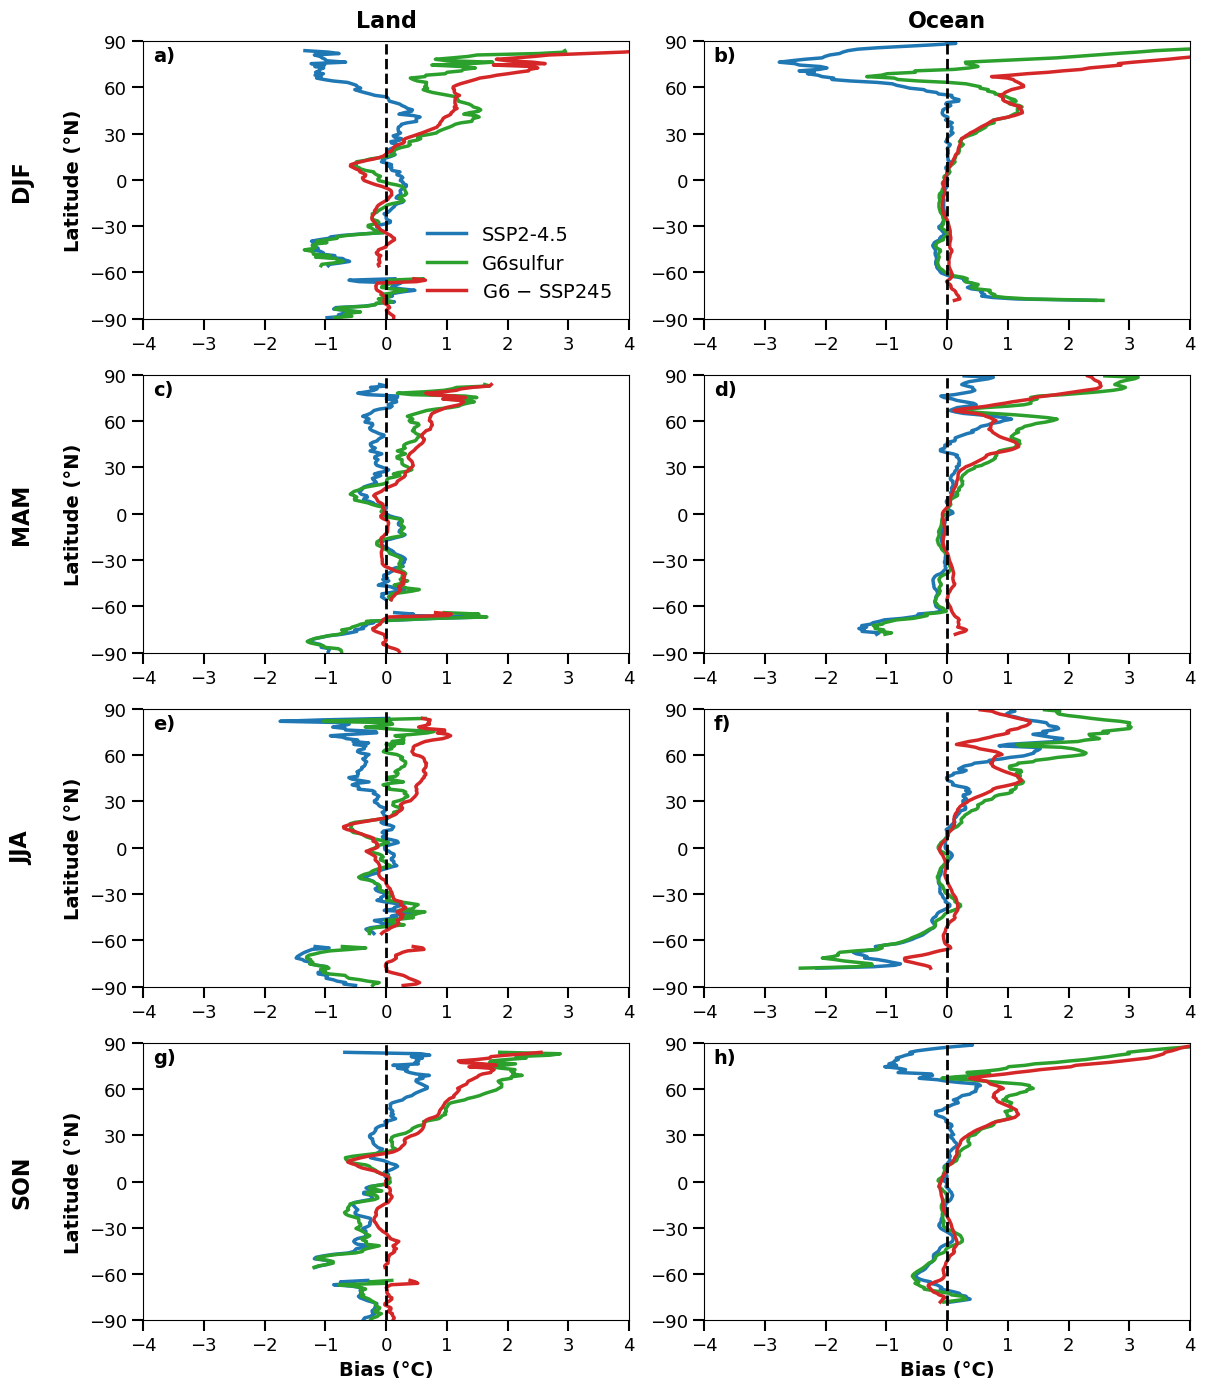

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ----------------------------
# Configuration
# ----------------------------
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
data_dir = Path("../data")

var_name = 'tas'
scenarios = ['g6sulfur', 'ssp245']
model_key = 'pred_grid'

# Seasons
seasons = {
    'DJF': [12, 1, 2],
    'MAM': [3, 4, 5],
    'JJA': [6, 7, 8],
    'SON': [9, 10, 11]
}

season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# ----------------------------
# Helper Functions
# ----------------------------
def load_land_mask(mask_file):
    """Load land-sea mask."""
    ds_mask = xr.open_dataset(mask_file)
    land_mask = ds_mask['sftlf'].values > 50.0
    ds_mask.close()
    return land_mask

def calculate_seasonal_bias(pred_data, truth_data, time, season_months):
    """
    Calculate seasonal mean bias.
    
    Args:
        pred_data: (time, lat, lon) array
        truth_data: (time, lat, lon) array
        time: time coordinate
        season_months: list of months for the season
    
    Returns:
        seasonal_bias: (lat, lon) array
    """
    months = time.dt.month.values
    season_mask = np.isin(months, season_months)
    
    bias = pred_data - truth_data
    seasonal_bias_timeseries = bias[season_mask]
    seasonal_mean_bias = np.mean(seasonal_bias_timeseries, axis=0)
    
    return seasonal_mean_bias

def compute_zonal_mean_bias(bias_2d, land_mask, mask_type):
    """
    Compute zonal mean (longitude average) for land or ocean.
    
    Args:
        bias_2d: (lat, lon) bias array
        land_mask: (lat, lon) boolean mask (True=land)
        mask_type: 'land' or 'ocean'
    
    Returns:
        zonal_mean: (lat,) array
    """
    if mask_type == 'land':
        masked_bias = np.where(land_mask, bias_2d, np.nan)
    elif mask_type == 'ocean':
        masked_bias = np.where(~land_mask, bias_2d, np.nan)
    else:
        masked_bias = bias_2d
    
    # Take mean over longitude (ignoring NaN)
    zonal_mean = np.nanmean(masked_bias, axis=1)
    
    return zonal_mean

# ----------------------------
# Load data
# ----------------------------
print("Loading data...")
data = {}

for scenario in scenarios:
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds = xr.open_dataset(residual_file)
    
    data[scenario] = {
        'pred': ds[model_key].values,
        'truth': ds['groundtruth'].values,
        'time': ds.time,
        'lat': ds.lat.values,
        'lon': ds.lon.values
    }
    print(f"  Loaded {scenario}")

# Get coordinates
lat = data['g6sulfur']['lat']
lon = data['g6sulfur']['lon']

# Load land mask
print("\nLoading land mask...")
land_mask_file = data_dir / "sftlf_fx_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn.nc"
land_mask = load_land_mask(land_mask_file)

# ----------------------------
# Calculate seasonal biases and zonal means
# ----------------------------
print("\nCalculating seasonal biases...")
zonal_results = {
    'land': {},
    'ocean': {}
}

for mask_type in ['land', 'ocean']:
    for season_name, season_months in seasons.items():
        zonal_results[mask_type][season_name] = {}
        
        for scenario in scenarios:
            # Calculate seasonal bias (2D)
            bias_2d = calculate_seasonal_bias(
                data[scenario]['pred'],
                data[scenario]['truth'],
                data[scenario]['time'],
                season_months
            )
            
            # Compute zonal mean
            zonal_mean = compute_zonal_mean_bias(bias_2d, land_mask, mask_type)
            zonal_results[mask_type][season_name][scenario] = zonal_mean
        
        # Compute delta-bias
        delta_bias = (zonal_results[mask_type][season_name]['g6sulfur'] - 
                     zonal_results[mask_type][season_name]['ssp245'])
        zonal_results[mask_type][season_name]['delta'] = delta_bias

# ----------------------------
# Create 4x2 subplot figure
# ----------------------------
fig, axes = plt.subplots(4, 2, figsize=(12, 14))

colors = {
    'ssp245': '#1f77b4',    # Blue
    'g6sulfur': '#2ca02c',  # Green
    'delta': '#d62728'      # Red
}

mask_labels = ['Land', 'Ocean']

for row_idx, season_name in enumerate(season_labels):
    for col_idx, mask_type in enumerate(['land', 'ocean']):
        ax = axes[row_idx, col_idx]
        
        # Get data
        bias_ssp245 = zonal_results[mask_type][season_name]['ssp245']
        bias_g6 = zonal_results[mask_type][season_name]['g6sulfur']
        delta_bias = zonal_results[mask_type][season_name]['delta']
        
        # Plot SSP2-4.5 (blue, no markers)
        ax.plot(bias_ssp245, lat, color=colors['ssp245'], 
                linewidth=2.5, label='SSP2-4.5')
        
        # Plot G6sulfur (green, no markers)
        ax.plot(bias_g6, lat, color=colors['g6sulfur'], 
                linewidth=2.5, label='G6sulfur')
        
        # Plot delta-bias (red, no markers)
        ax.plot(delta_bias, lat, color=colors['delta'], 
                linewidth=2.5, label=r'G6 $-$ SSP245')
        
        # Add thick dashed black line at x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=1)
        
        # Formatting
        ax.set_ylim(-90, 90)
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_xlim(-4, 4)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=13, 
                      length=8, width=1.5)
        
        # Labels
        if row_idx == 3:  # Bottom row
            ax.set_xlabel('Bias (°C)', fontsize=14, fontweight='bold')
        
        if col_idx == 0:  # Left column
            ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold')
        
        # Title for top row
        if row_idx == 0:
            ax.set_title(mask_labels[col_idx], fontsize=16, fontweight='bold', pad=10)
        
        # Season label on left side
        if col_idx == 0:
            ax.text(-0.25, 0.5, season_name, 
                   transform=ax.transAxes,
                   fontsize=16, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Legend (only for top-left panel, no frame, best location)
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=14, loc='lower right', frameon=False)
        
        # Add panel label
        panel_label = chr(97 + row_idx * 2 + col_idx) + ')'
        ax.text(0.02, 0.98, panel_label, 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top')

plt.tight_layout()
output_file = figures_dir / "g6sulfur_ssp245_bias_lat_profile.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

Loading data...
  Loaded ssp245
  Loaded g6sulfur

Loading land mask...

Calculating seasonal biases...


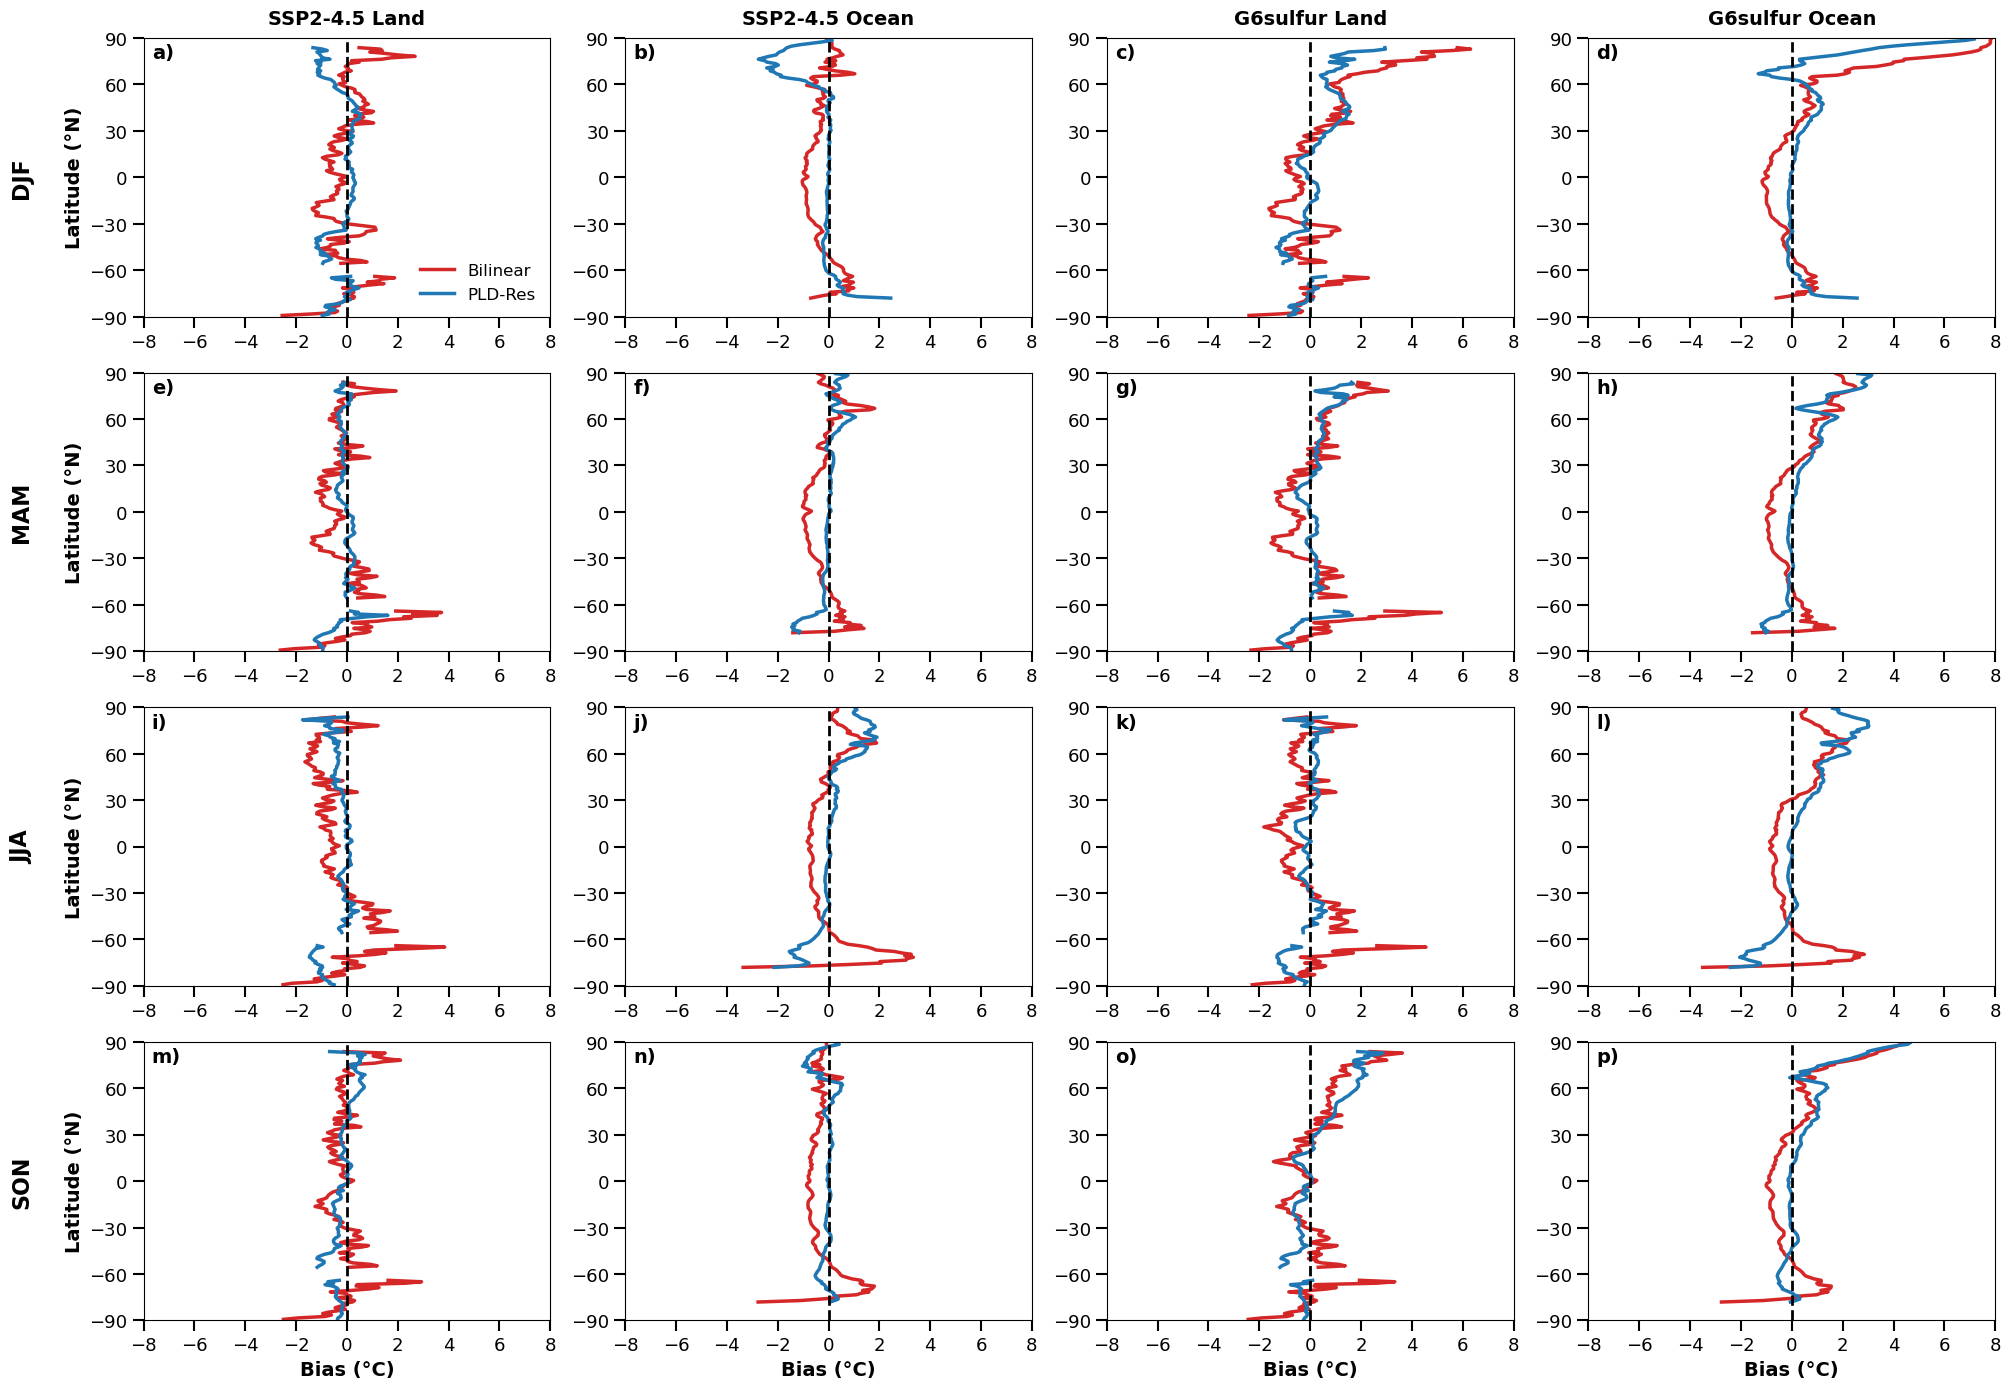

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
data_dir = Path("../data")

var_name = 'tas'
scenarios = ['ssp245', 'g6sulfur']

# Seasons
seasons = {
    'DJF': [12, 1, 2],
    'MAM': [3, 4, 5],
    'JJA': [6, 7, 8],
    'SON': [9, 10, 11]
}

season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# ----------------------------
# Helper Functions
# ----------------------------
def load_land_mask(mask_file):
    """Load land-sea mask."""
    ds_mask = xr.open_dataset(mask_file)
    land_mask = ds_mask['sftlf'].values > 50.0
    ds_mask.close()
    return land_mask

def calculate_seasonal_bias(pred_data, truth_data, time, season_months):
    """Calculate seasonal mean bias."""
    months = time.dt.month.values
    season_mask = np.isin(months, season_months)
    
    bias = pred_data - truth_data
    seasonal_bias_timeseries = bias[season_mask]
    seasonal_mean_bias = np.mean(seasonal_bias_timeseries, axis=0)
    
    return seasonal_mean_bias

def compute_zonal_mean_bias(bias_2d, land_mask, mask_type):
    """Compute zonal mean (longitude average) for land or ocean."""
    if mask_type == 'land':
        masked_bias = np.where(land_mask, bias_2d, np.nan)
    elif mask_type == 'ocean':
        masked_bias = np.where(~land_mask, bias_2d, np.nan)
    else:
        masked_bias = bias_2d
    
    zonal_mean = np.nanmean(masked_bias, axis=1)
    return zonal_mean

# ----------------------------
# Load data
# ----------------------------
print("Loading data...")
data = {}

for scenario in scenarios:
    # Load residual results (PLD-Res)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_res = xr.open_dataset(residual_file)
    
    # Load main results (Bilinear)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    data[scenario] = {
        'pred_pld': ds_res['pred_grid'].values,
        'pred_bilinear': ds_main['input'].values,
        'truth': ds_res['groundtruth'].values,
        'time': ds_res.time,
        'lat': ds_res.lat.values,
        'lon': ds_res.lon.values
    }
    print(f"  Loaded {scenario}")

# Get coordinates
lat = data['ssp245']['lat']

# Load land mask
print("\nLoading land mask...")
land_mask_file = data_dir / "sftlf_fx_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn.nc"
land_mask = load_land_mask(land_mask_file)

# ----------------------------
# Calculate seasonal biases and zonal means
# ----------------------------
print("\nCalculating seasonal biases...")
zonal_results = {}

for mask_type in ['land', 'ocean']:
    zonal_results[mask_type] = {}
    for season_name, season_months in seasons.items():
        zonal_results[mask_type][season_name] = {}
        
        for scenario in scenarios:
            # Calculate seasonal bias for PLD-Res
            bias_pld = calculate_seasonal_bias(
                data[scenario]['pred_pld'],
                data[scenario]['truth'],
                data[scenario]['time'],
                season_months
            )
            zonal_pld = compute_zonal_mean_bias(bias_pld, land_mask, mask_type)
            zonal_results[mask_type][season_name][f'{scenario}_pld'] = zonal_pld
            
            # Calculate seasonal bias for Bilinear
            bias_bilinear = calculate_seasonal_bias(
                data[scenario]['pred_bilinear'],
                data[scenario]['truth'],
                data[scenario]['time'],
                season_months
            )
            zonal_bilinear = compute_zonal_mean_bias(bias_bilinear, land_mask, mask_type)
            zonal_results[mask_type][season_name][f'{scenario}_bilinear'] = zonal_bilinear

# ----------------------------
# Create 4x4 subplot figure
# ----------------------------
fig, axes = plt.subplots(4, 4, figsize=(20, 14))

colors = {
    'pld': '#1f77b4',       # Blue for PLD-Res
    'bilinear': '#d62728',  # Red for Bilinear
}

# Column configuration: (scenario, mask_type)
columns = [
    ('ssp245', 'land'),
    ('ssp245', 'ocean'),
    ('g6sulfur', 'land'),
    ('g6sulfur', 'ocean')
]

column_titles = [
    'SSP2-4.5 Land',
    'SSP2-4.5 Ocean',
    'G6sulfur Land',
    'G6sulfur Ocean'
]

for row_idx, season_name in enumerate(season_labels):
    for col_idx, (scenario, mask_type) in enumerate(columns):
        ax = axes[row_idx, col_idx]
        
        # Get data
        bias_pld = zonal_results[mask_type][season_name][f'{scenario}_pld']
        bias_bilinear = zonal_results[mask_type][season_name][f'{scenario}_bilinear']
        
        # Plot Bilinear (red solid line)
        ax.plot(bias_bilinear, lat, color=colors['bilinear'], 
                linewidth=2.5, linestyle='-', label='Bilinear')
        
        # Plot PLD-Res (blue solid line)
        ax.plot(bias_pld, lat, color=colors['pld'], 
                linewidth=2.5, linestyle='-', label='PLD-Res')
        
        # Add thick dashed black line at x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=1)
        
        # Formatting
        ax.set_ylim(-90, 90)
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_xlim(-8, 8)
        ax.set_xticks(np.arange(-8, 9, 2))
        
        ax.tick_params(axis='both', which='major', labelsize=13, 
                      length=8, width=1.5)
        
        # Labels
        if row_idx == 3:  # Bottom row
            ax.set_xlabel('Bias (°C)', fontsize=14, fontweight='bold')
        
        if col_idx == 0:  # Left column
            ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold')
        
        # Title for top row
        if row_idx == 0:
            ax.set_title(column_titles[col_idx], fontsize=14, fontweight='bold', pad=10)
        
        # Season label on left side
        if col_idx == 0:
            ax.text(-0.3, 0.5, season_name, 
                   transform=ax.transAxes,
                   fontsize=16, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Legend (only for top-left panel)
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=12, loc='lower right', frameon=False)
        
        # Add panel label
        panel_label = chr(97 + row_idx * 4 + col_idx) + ')'
        ax.text(0.02, 0.98, panel_label, 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top')

plt.tight_layout()
output_file = figures_dir / "g6sulfur_ssp245_bias_lat_profile_02.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()



Loading data...
  Loaded ssp126
  Loaded ssp245
  Loaded g6sulfur
  Loaded ssp585


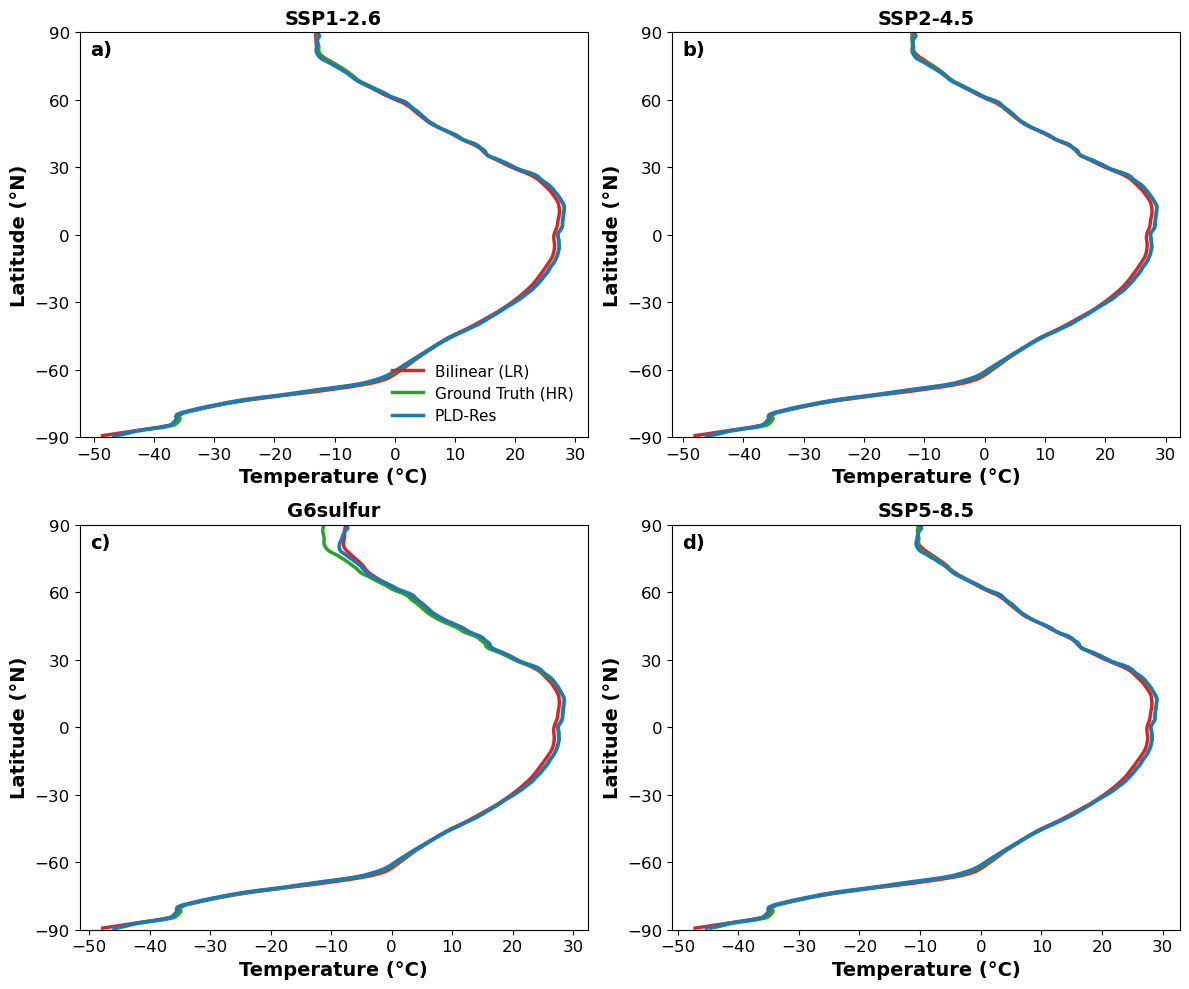

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'tas'
scenarios = ['ssp126', 'ssp245', 'g6sulfur', 'ssp585']

scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'g6sulfur': 'G6sulfur',
    'ssp585': 'SSP5-8.5'
}

# ----------------------------
# Load data and compute latitude profiles
# ----------------------------
print("Loading data...")
lat_profiles = {}

for scenario in scenarios:
    # Load residual results (PLD-Res and ground truth)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_res = xr.open_dataset(residual_file)
    
    # Load main results (Bilinear)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    # Get latitude
    lat = ds_res.lat.values
    
    # Compute zonal mean (average over longitude), then temporal mean (average over time)
    # Shape: (time, lat, lon) -> (lat,)
    bilinear_profile = np.nanmean(ds_main['input'].values, axis=(0, 2))
    truth_profile = np.nanmean(ds_res['groundtruth'].values, axis=(0, 2))
    pld_res_profile = np.nanmean(ds_res['pred_grid'].values, axis=(0, 2))
    
    lat_profiles[scenario] = {
        'bilinear': bilinear_profile,
        'truth': truth_profile,
        'pld_res': pld_res_profile,
        'lat': lat
    }
    
    ds_res.close()
    ds_main.close()
    print(f"  Loaded {scenario}")

# ----------------------------
# Create 2x2 subplot figure
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = {
    'bilinear': '#d62728',  # Red
    'truth': '#2ca02c',     # Green
    'pld_res': '#1f77b4'    # Blue
}

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    lat = lat_profiles[scenario]['lat']
    
    # Plot each profile
    ax.plot(lat_profiles[scenario]['bilinear'], lat, 
            color=colors['bilinear'], linewidth=2.5, label='Bilinear (LR)')
    ax.plot(lat_profiles[scenario]['truth'], lat, 
            color=colors['truth'], linewidth=2.5, label='Ground Truth (HR)')
    ax.plot(lat_profiles[scenario]['pld_res'], lat, 
            color=colors['pld_res'], linewidth=2.5, label='PLD-Res')
    
    # Formatting
    ax.set_ylim(-90, 90)
    ax.set_yticks(np.arange(-90, 91, 30))
    ax.set_xlabel('Temperature (°C)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold')
    ax.set_title(scenario_labels[scenario], fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', labelsize=12)
    
    # Panel label
    ax.text(0.02, 0.98, f'{chr(97 + idx)})', transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top')
    
    # Legend (only first panel)
    if idx == 0:
        ax.legend(fontsize=11, loc='lower right', frameon=False)

plt.tight_layout()
# output_file = figures_dir / "latitude_profile_comparison.png"
# plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()